In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from scripts.helper import prepare_gpr_results, downscale_map

from scripts.imagedata import ImageData
from scripts.neutralliner import NeutralLiner
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm
from skimage.measure import label
import scipy.stats as stats
import matplotlib.dates as mdates
from astropy.io import fits
import scipy.signal as signal
import json
from scripts.config import device, PATH_TO_MCINTOSH


# Synthetic dataset

In [ ]:
PATH_TO_RESULTS = './Tests/_FINAL/'

## Stages

The mean of the minimum values is 0.0315 with a 99% confidence interval of [0.024969235649634876, 0.03803076435036513], ci=0.006530764350365125


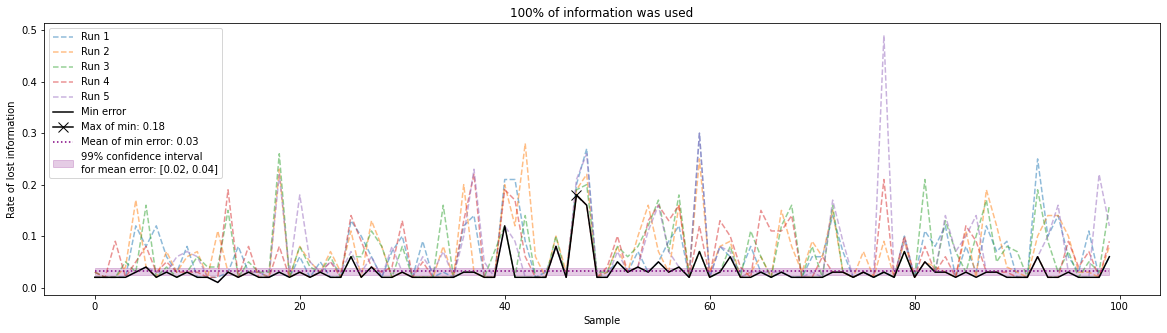

The mean of the minimum values is 0.048200000000000014 with a 99% confidence interval of [0.038795342609111175, 0.05760465739088885], ci=0.009404657390888835


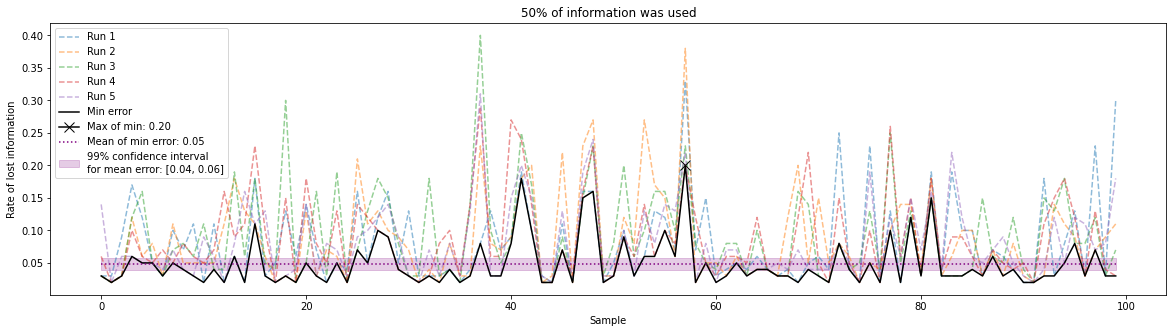

The mean of the minimum values is 0.06020000000000001 with a 99% confidence interval of [0.05038256604605869, 0.07001743395394133], ci=0.009817433953941326


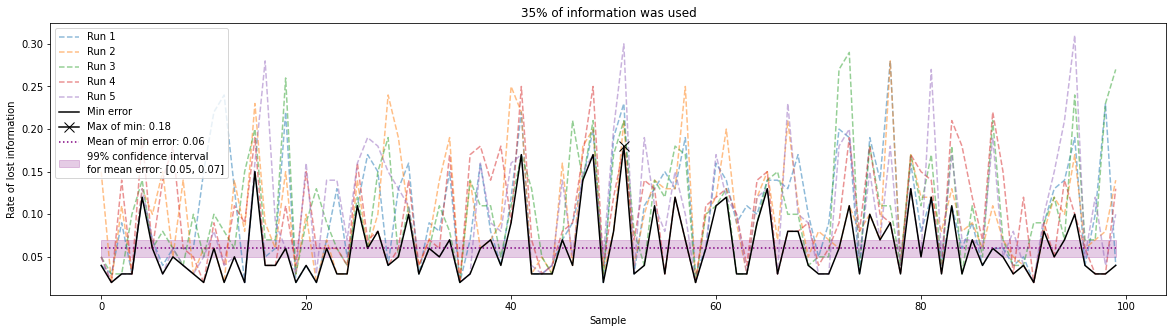

The mean of the minimum values is 0.09500000000000001 with a 99% confidence interval of [0.08396013206600733, 0.1060398679339927], ci=0.011039867933992689


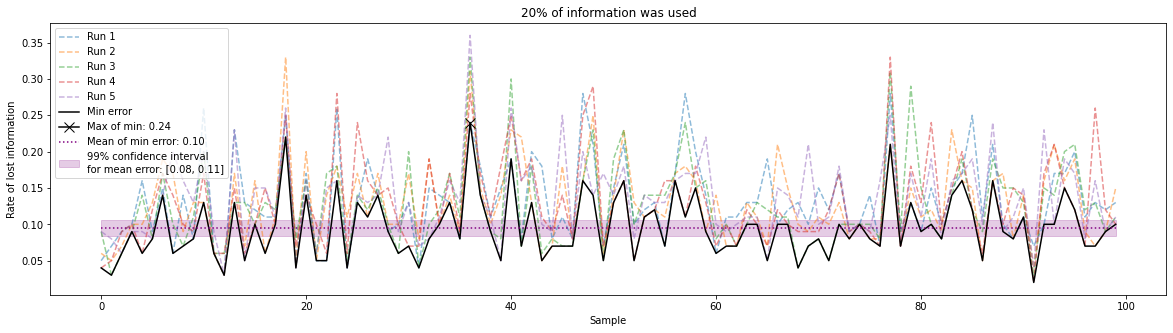

The mean of the minimum values is 0.13269999999999998 with a 99% confidence interval of [0.12136058447537967, 0.1440394155246203], ci=0.011339415524620306


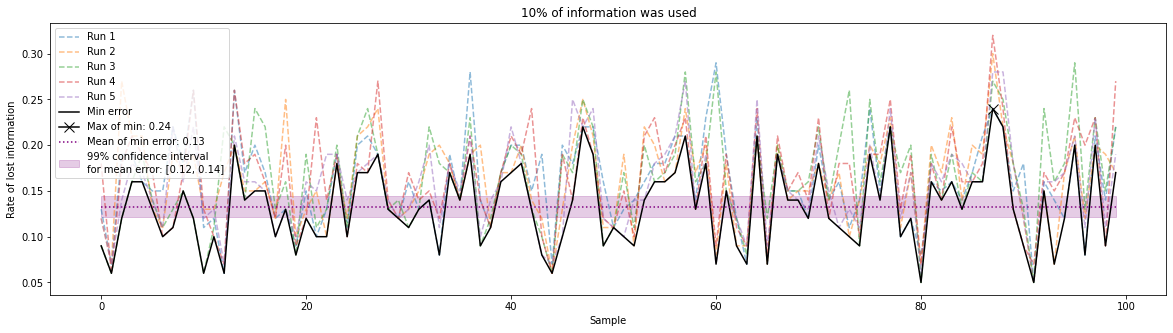

In [23]:
stages = ('0B', '50B', '65B', '80B', '90B')
def plot_results(stage):
    res = []
    with open(os.path.join(PATH_TO_RESULTS, stage, 'res.txt'), 'r') as f:
        for line in f:
            if line.startswith('Error'):
                res.append(float(line.split(': ')[1]))
    res = np.array(res).reshape(-1, 5)
    rmin = res.min(axis=1)
    # Compute the average of the minimum values
    m = rmin.mean()
    # Compute the standard deviation of the minimum values
    s = rmin.std()
    # Compute the 99% confidence interval
    ci = 2.58 * s / np.sqrt(len(rmin))
    l, r = m - ci, m + ci
    print(f'The mean of the minimum values is {m} with a 99% confidence interval of [{l}, {r}], ci={ci}')
    plt.figure(figsize=(20, 5))
    for i in range(5):
        plt.plot(res[:, i], label=f'Run {i+1}', alpha=0.5, linestyle='--')
    plt.plot(rmin, label='Min error', color='black')
    plt.plot(rmin.argmax(), rmin.max(), marker='x', markersize=10, label=f'Max of min: {rmin.max():.2f}', color='black')
    plt.plot([m] * len(rmin), label=f'Mean of min error: {m:.2f}', color='purple', linestyle='dotted')
    # fill the 99% confidence interval
    plt.fill_between(range(len(rmin)), l, r, alpha=0.2, color='purple', label=f'99% confidence interval\nfor mean error: [{l:.2f}, {r:.2f}]')
    plt.title(f'{100 - int(stage[:-1])}% of information was used')
    plt.xlabel('Sample')
    plt.ylabel('Rate of lost information')
    plt.legend()
    plt.show()


for stage in stages:
    plot_results(stage)
    # break



## Dataset

In [220]:
samples = torch.load('./Tests/_FINAL/samples.pt')

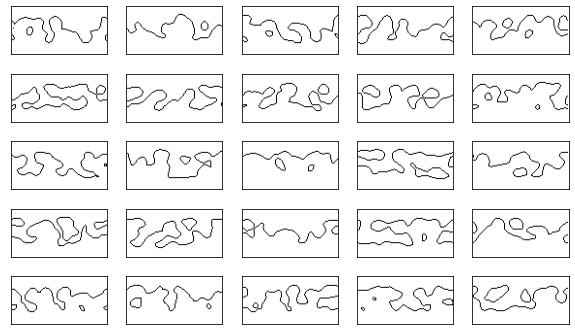

In [226]:
# plot 5x5 random samples
plt.figure(figsize=(10, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    original, sign, splitted = prepare_gpr_results(samples[i], p=0.5)
    # do not show values on the axes
    plt.xticks([])
    plt.yticks([])
    plt.imshow(original, cmap='gray')


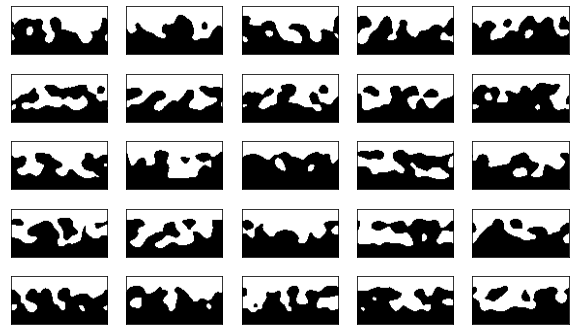

In [228]:
plt.figure(figsize=(10, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    original, sign, splitted = prepare_gpr_results(samples[i], p=0.5)
    # do not show values on the axes
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sign, cmap='gray')


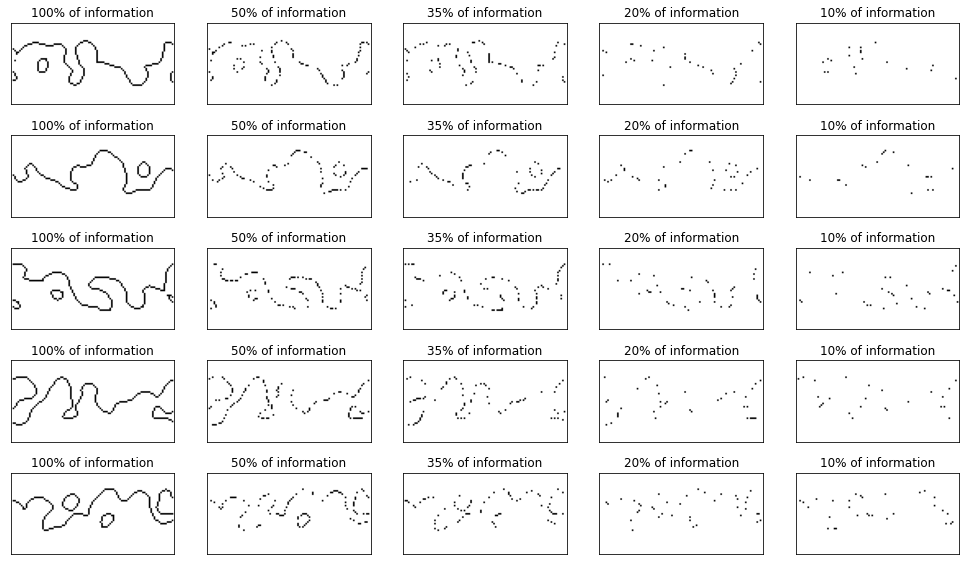

In [236]:
plt.figure(figsize=(17, 10))
for i in range(5):
    sample = samples[i]
    for j, p in enumerate([0, 0.5, 0.65, 0.8, 0.9]):
        _, _, splitted = prepare_gpr_results(sample, p=p)
        plt.subplot(5, 5, 5*i + j+1)
        plt.imshow(splitted, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'{100 - int(p * 100)}% of information')

        

## Multiscale

In [ ]:
samples = torch.load('./Tests/_FINAL/samples.pt')
sample = samples[0]
original, sign, splitted = prepare_gpr_results(sample, p=0.8)

In [ ]:
from ipywidgets import interact
@interact(i=(0, len(samples)-1))
def _(i=0):
    plt.figure(figsize=(15, 10))
    sample = samples[i]
    original, sign, splitted = prepare_gpr_results(sample, p=0.8)
    for i, s in enumerate([10, 5, 3, 1]):
        plt.subplot(1, 5, i+1)
        plt.imshow(downscale_map(splitted, s), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Downscaled by {s}x' if s > 1 else 'Original splitted image')
    plt.subplot(1, 5, 5)
    plt.imshow(original, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original image')

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

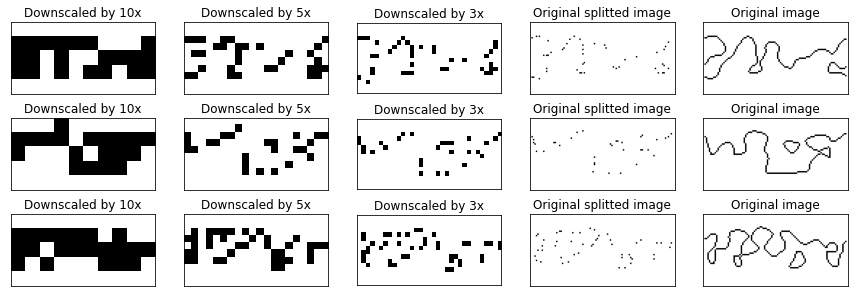

In [ ]:
plt.figure(figsize=(15, 5))

for k, j in enumerate([3, 11, 25]):
    sample = samples[j]
    original, sign, splitted = prepare_gpr_results(sample, p=0.8)
    for i, s in enumerate([10, 5, 3, 1]):
        plt.subplot(3, 5, 5*k + i+1)
        plt.imshow(downscale_map(splitted, s), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Downscaled by {s}x' if s > 1 else 'Original splitted image')
    plt.subplot(3, 5, 5*k + 5)
    plt.imshow(original, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original image')

## Final graph

In [ ]:
PATH_TO_RESULTS = './Tests/_FINAL/'
stages = ('0B', '50B', '65B', '80B', '90B')
ers = []
for stage in stages:
    res = []
    with open(os.path.join(PATH_TO_RESULTS, stage, 'res.txt'), 'r') as f:
        for line in f:
            if line.startswith('Error'):
                res.append(100*float(line.split(': ')[1]))
    res = np.array(res).reshape(-1, 5)
    rmin = res.min(axis=1)
    # Compute the average of the minimum values
    m = rmin.mean()
    # Compute the standard deviation of the minimum values
    s = rmin.std()
    # Compute the 99% confidence interval
    ers.append(m)
ers



[3.15, 4.82, 6.02, 9.5, 13.27]

In [ ]:
stage = '95B'
res = []
with open(os.path.join(PATH_TO_RESULTS, stage, 'res.txt'), 'r') as f:
    for line in f:
        if line.startswith('Error'):
            res.append(100*float(line.split(': ')[1]))
res = np.array(res).reshape(-1, 5)
rmin = res.min(axis=1)
# Compute the average of the minimum values
m = rmin.mean()
# Compute the standard deviation of the minimum values
s = rmin.std()
# Compute the 99% confidence interval
ers.append(m)
ers


[3.15, 4.82, 6.02, 9.5, 13.27, 16.879310344827587]

In [ ]:
# compute the 99% confidence interval
ci = 2.58 * s / np.sqrt(len(rmin))
l, r = m - ci, m + ci
print(f'The mean of the minimum values is {m} with a 99% confidence interval of [{l}, {r}], ci={ci}')

The mean of the minimum values is 16.879310344827587 with a 99% confidence interval of [15.249665087362969, 18.508955602292207], ci=1.6296452574646187


In [ ]:
ers[-1] = 20.0
stages = ('0B', '50B', '65B', '80B', '90B', '95B')

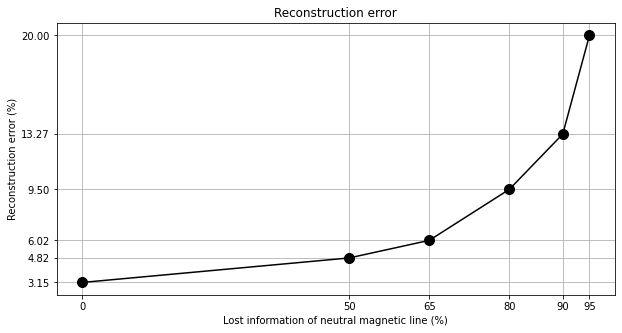

In [ ]:
# plot the results
# x is the percentage of information used
# y is the mean of the minimum values in percent
x = [int(stage[:-1]) for stage in stages]
y = ers
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', markersize=10, color='black')
# add the 99% confidence interval
# for i in range(len(x)):
#     plt.plot([x[i]] * 2, [y[i] - 2.58 * s / np.sqrt(len(rmin)), y[i] + 2.58 * s / np.sqrt(len(rmin))], color='black')
# add values on axis of plotted values in y
plt.yticks(y)
plt.xticks(x)

plt.title('Reconstruction error')
plt.xlabel('Lost information of neutral magnetic line (%)')
plt.ylabel('Reconstruction error (%)')
# add grid
plt.grid()
plt.show()

# Kislovodsk

In [6]:
import torch
from matplotlib import pyplot as plt

In [7]:
samples = torch.load('Kislovodsk.pt')

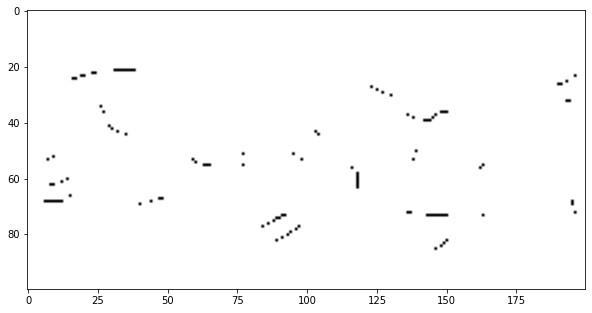

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(samples[0], cmap='gray')


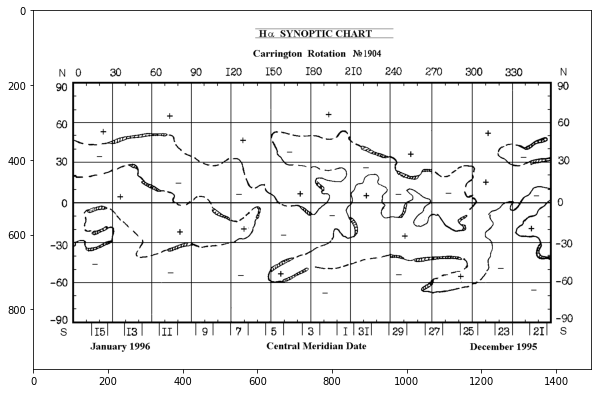

In [11]:
# open the image
from helper import open_img_as_array

img = open_img_as_array('./Kislovodsk/sn1996k1904eng.gif')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')


In [12]:
samples.shape

torch.Size([18, 100, 200])

Text(0.5, 1.0, 'Synoptic map')

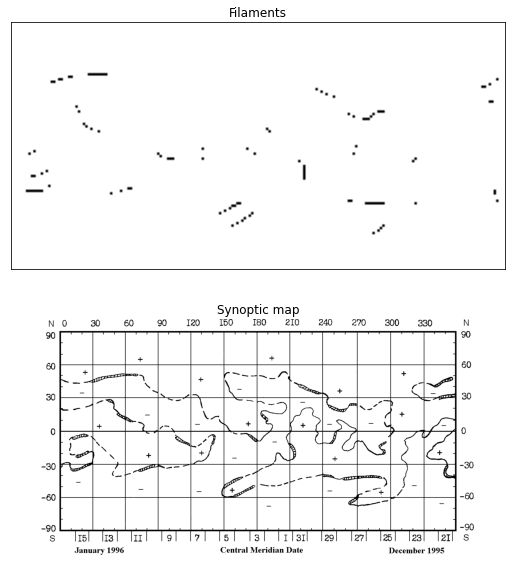

In [32]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(samples[0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Filaments')
plt.subplot(2, 1, 2)
plt.axis('off')
plt.imshow(img[150:-10], cmap='gray')
plt.title('Synoptic map')

# Gif research

In [6]:
from imagedata import ImageData
from model import Net
import torch
import matplotlib.pyplot as plt
from config import device


In [11]:
img = ImageData('./imgs/100200.png', 'path')

In [12]:
model = Net([img], 1e-3)
model.to(device)

Net(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=6, out_features=12, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=12, out_features=24, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=24, out_features=1, bias=True)
    (7): Tanh()
  )
)

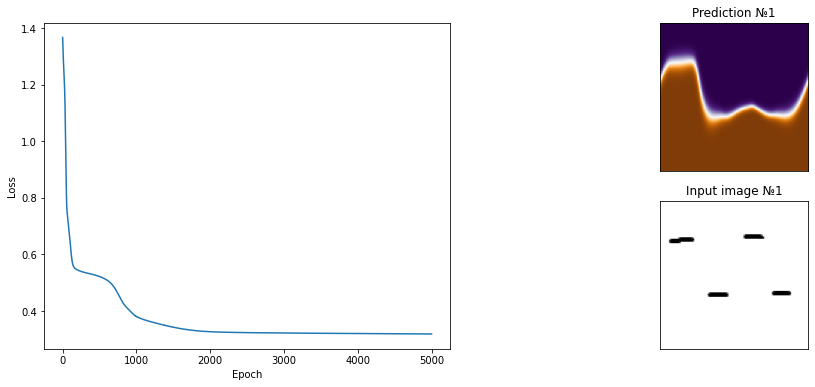

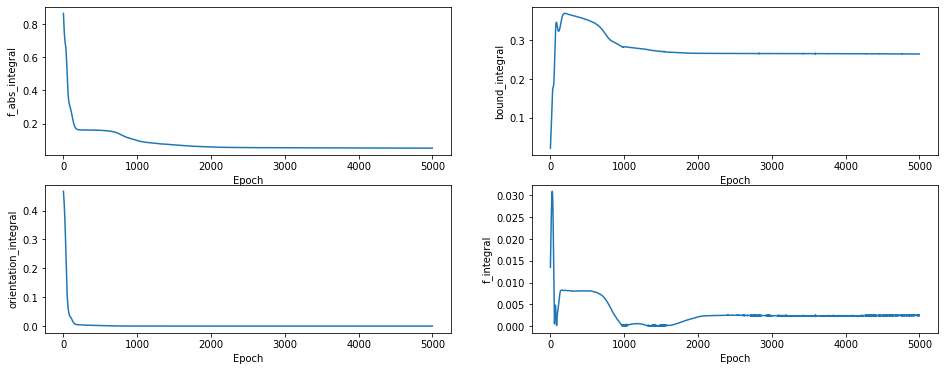

In [15]:
model = model.restart_model(lr=1e-3)
model.start_training(5000, True, False, 0.1, 100)

# McIntosh

## Article

### Examples

In [72]:
imgdata = ImageData('./imgs/fits/McIntosh/ptmc_compo_sm_19541221_150036_cr1355k_l3.fits', 'fits')
img = imgdata.img_array
model = NeutralLiner([imgdata], 1e-3)
data_3d = model.data_list[0]
data_3d

tensor([[ 1.0000,  0.0000,  1.5708],
        [ 0.9999,  0.0112,  1.5708],
        [ 0.9998,  0.0224,  1.5708],
        ...,
        [ 0.8295, -0.5585, -1.5708],
        [ 0.8357, -0.5492, -1.5708],
        [ 0.8418, -0.5398, -1.5708]])

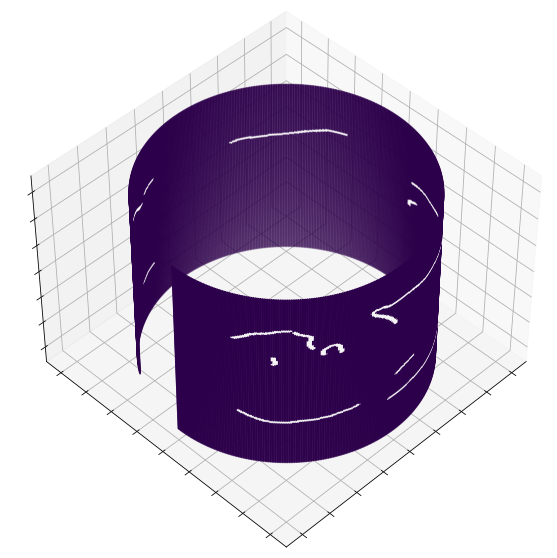

In [79]:
x, y, z = data_3d[:, 0], data_3d[:, 1], data_3d[:, 2]
color = img.flatten()

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d', elev=45, azim=45)
# plor image but rotate view
ax.scatter(x, y, -z, c=color, cmap='PuOr', s=1, vmin=-1, vmax=1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# delete values on axis
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.savefig('approach_3d.png', bbox_inches='tight')


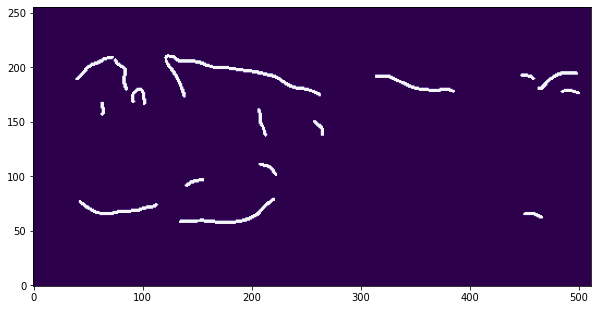

In [77]:
plt.figure(figsize=(10, 10))
plt.imshow(img.astype(float), cmap='PuOr', vmin=-1, vmax=1, origin='lower')
plt.savefig('approach_2d.png', bbox_inches='tight')

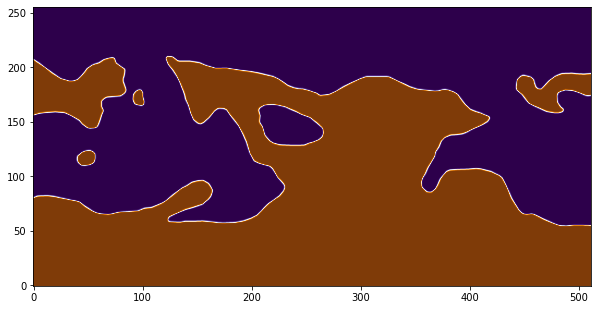

In [89]:
plt.figure(figsize=(10, 10))
plt.imshow(-imgdata.target_img, cmap='PuOr', vmin=-1, vmax=1, origin='lower')

In [92]:
img = imgdata.target_img
w, h = img.shape
x, y = np.meshgrid(np.arange(h), np.arange(w))
z = img


z= img
sh_1, sh_0 = z.shape
x, y = np.linspace(0, sh_0, sh_0), np.linspace(0, sh_1, sh_1)
fig = go.Figure(data=[go.Surface(z=-z, x=x, y=y, colorscale='PuOr', showscale=False, opacity=0.9)])

fig.update_traces(contours_z=dict(show=True, start=-0.1, end=0.1, size=10, color='green', width=5))

# delete axis ticks
fig.update_layout(scene=dict(
                            xaxis=dict(showticklabels=False),
                            yaxis=dict(showticklabels=False),
                            zaxis=dict(showticklabels=False),
                            xaxis_title='',
                            yaxis_title='',
                            zaxis_title='',
                            ),
                width=700,
                height=700,
                margin=dict(r=20, l=10, b=10, t=10))

# Сделай одинаковый масштаб по осям
fig.update_layout(scene_aspectmode='manual',
                scene_aspectratio=dict(x=2, y=1, z=1))
# make picture bigger
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

### Tests results

#### Attention

In [ ]:
height, width = (256, 512)
x = np.linspace(0, width - 1, width)
y = np.linspace(0, height - 1, height)
X, Y = np.meshgrid(x, y)
COORDS = np.dstack((X, Y))

def create_weight_array(centers, radii, coords=COORDS):
    weights = []
    for center, r in zip(centers, radii):
        cov = torch.eye(2) * r ** 2
        rv = stats.multivariate_normal(mean=center[::-1], cov=cov)
        cur_weights = torch.tensor(rv.pdf(coords), dtype=torch.float32)
        weights.append(cur_weights / cur_weights.max())
    weights = torch.stack(weights).clamp(0, 1)
    return weights

def parse_filaments(img, scale_r):
    limg = label(img, background=1)
    filaments_labels = np.unique(limg)[1:]
    filaments_masks = [limg == label for label in filaments_labels]
    filaments_coords = [limg[mask] for mask in filaments_masks]
    # get coords in the form [[[x1, y1], [x2, y2], ...], [[x1, y1], [x2, y2], ...], ...]
    filaments_coords = [np.array(list(zip(*np.where(mask)))) for mask in filaments_masks]
    filaments_centers = np.array([np.mean(coords, axis=0) for coords in filaments_coords])
    filaments_radii = np.array([np.linalg.norm(center - coords, axis=1).max() for center, coords in zip(filaments_centers, filaments_coords)])
    filaments_radii *= scale_r
    circle_masks = []
    for center, r in zip(filaments_centers, filaments_radii):
        circle_mask = np.where((COORDS[:, :, 0] - center[1]) ** 2 + (COORDS[:, :, 1] - center[0]) ** 2 <= r ** 2, True, False)
        circle_masks.append(circle_mask)
    return filaments_centers, filaments_radii, circle_masks, filaments_coords

In [ ]:
path_to_weights = './state_dict/fits/averaging/63/ptmc_compo_sm_19541221_150036_cr1355k_l3/'

@interact(map_name=os.listdir(PATH_TO_MCINTOSH), weight=os.listdir(path_to_weights), scaler=(0.5, 2, 0.1))
def _(map_name, weight, scaler):
    imgdata = ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, map_name), data_mode='fits')
    model = NeutralLiner(image_list=[imgdata],
                        lr=5e-3,
                        help_step_size=63,
                        mode='3d',
                        arch=[3, 6, 12, 24, 12, 6, 3, 1],
                        weight_decay=1e-4)
    model.load_state_dict(torch.load(os.path.join(path_to_weights, weight), map_location=device))
    model.to(device)
    prediction = model.test_model(need_plot=False)[0].view(model.image_list[0].img_array.shape).cpu().detach()

    img = imgdata.img_array
    
    filaments_centers, filaments_radii, circle_masks, filaments_coords = parse_filaments(img, scaler)
    # sums of the pixels in the circles for prediction
    abs_sums = [prediction[circle_mask].sum().abs() / len(prediction[circle_mask]) for circle_mask in circle_masks]
    # sums_abs = [prediction[circle_mask].abs().sum() / len(prediction[circle_mask]) for circle_mask in circle_masks]
    # for i, (abssum, sumabs) in enumerate(zip(abs_sums, sums_abs)):
    #     print(f'Filament {i}\tabs_sum {abssum:.2f}\tsum_abs {sumabs:.2f}' + '\t' + ('good' if abssum < 0.5 else 'bad'))
    for i, abssum in enumerate(abs_sums):
        print(f'Filament {i}\tabs_sum: {abssum:.2f}' + '\t' + ('good' if abssum < 0.5 else 'bad'))

    # get weights
    good_regions = torch.tensor([abssum < 0.5 for abssum in abs_sums])
    weights = create_weight_array(filaments_centers, filaments_radii)
    weights = weights[good_regions].sum(dim=0).clamp(0, 1)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(prediction, cmap='PuOr')
    plt.title(f'Prediction for map {map_name}')

    # add circles
    for center, coords, r in zip(filaments_centers, filaments_coords, filaments_radii):
        plt.scatter(center[1], center[0], c='red', s=50)
        # add text with filament number
        plt.text(center[1], center[0],
                f'{np.where(filaments_centers == center)[0][0]}', fontsize=10, color='red')
        # plot Circle with radius max_dist[i]
        plt.gca().add_patch(Circle(center[::-1],
                            r,
                            linewidth=1,
                            edgecolor='r',
                            facecolor='none',
                            linestyle='--'))
        # plot filaments green
        plt.scatter(coords[:, 1], coords[:, 0], c='green', s=4, alpha=0.5)
        plt.xlim(0, 512)
        plt.ylim(0, 256)
    # change orientation of axis
    plt.gca().invert_yaxis()
    plt.subplot(1, 3, 2)
    plt.imshow(weights * prediction, cmap='PuOr')
    plt.title(f'Prediction with weights')
    plt.subplot(1, 3, 3)
    plt.imshow(weights * prediction > 0, cmap='PuOr')
    w = (weights * prediction > 0).float() == torch.tensor(imgdata.target_img).float()
    error = 1 - w.sum() / (256 * 512)
    mse = torch.nn.MSELoss()((weights * prediction > 0).float(), torch.tensor(imgdata.target_img))
    print(f'Error: {error:.4f}')
    print(f'Error1: {mse:.4f}')

In [ ]:
help_step_size = 31
path_to_weights = f'./state_dict/fits/averaging/{help_step_size}/'
mapnames = os.listdir(path_to_weights)
filaments = []
targets = []
mean_predictions = []
predictions = []

In [ ]:
# get mean preds
for mapname in tqdm(mapnames):
    imgdata = ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, mapname + '.fits'), data_mode='fits')
    filaments.append(imgdata.img_array)
    targets.append(imgdata.target_img)
    model = NeutralLiner(image_list=[imgdata],
                        lr=5e-3,
                        help_step_size=help_step_size,
                        mode='3d',
                        arch=[3, 6, 12, 24, 12, 6, 3, 1],
                        weight_decay=1e-4)
    map_predictions = []
    for weight in os.listdir(os.path.join(path_to_weights, mapname)):
        model.load_state_dict(torch.load(os.path.join(path_to_weights, mapname, weight), map_location=device))
        model.to(device)
        prediction = model.test_model(need_plot=False)[0].view((256, 512)).cpu().detach()
        map_predictions.append(prediction)
    map_predictions = torch.stack(map_predictions)
    predictions.append(map_predictions)
    mean_prediction = torch.mean(map_predictions, dim=0)
    mean_predictions.append(mean_prediction)
filaments = torch.from_numpy(np.stack(filaments))
targets = torch.from_numpy(np.stack(targets))
mean_predictions = torch.stack(mean_predictions)
predictions = torch.stack(predictions)

In [ ]:
res_df = pd.DataFrame(columns=['map_name', 'region_threshold', 'mean_weighted_error_bin', 'mean_error_bin'])

for mapname, filament, target, preds, mean_prediction in tqdm(zip(mapnames, filaments, targets, predictions, mean_predictions), total=len(mapnames)):
    central = int(mapname.shape[0] * 5 / 18)
    filaments_centers, filaments_radii, circle_masks, _ = parse_filaments(filament, scale_r=1)
    weights = create_weight_array(filaments_centers, filaments_radii)
    target_bin = target > 0
    mean_prediction_bin = (mean_prediction > 0)[central:-central, :]
    normcoef = mean_prediction_bin.numel()
    mean_error_bin = 1 - (mean_prediction_bin == target_bin[central:-central, :]).sum() / normcoef
    all_abs_sums = []
    for prediction in preds:
        all_abs_sums.append([prediction[circle_mask].sum().abs() / len(prediction[circle_mask]) for circle_mask in circle_masks])
    all_abs_sums = np.array(all_abs_sums)
    cur_dir = f'./Tests/Fits/Mean/averaging/{help_step_size}/{mapname}/'
    os.makedirs(cur_dir, exist_ok=True)
    for region_threshold in (0.3, 0.4, 0.5, 0.6):
        mean_weighted_prediction = []
        for prediction, abssum in zip(preds, all_abs_sums):
            good_regions = np.array([abssum < region_threshold])
            weight = weights[good_regions].sum(dim=0).clamp(0, 1)
            weighted_prediction = weight * prediction
            mean_weighted_prediction.append(weighted_prediction)
        weighted_prediction = torch.stack(mean_weighted_prediction).mean(dim=0)
        mean_weighted_error_bin = 1 - ((weighted_prediction > 0) == target_bin)[central:-central, :].sum() / normcoef
        # plt.figure(figsize=(20, 16))
        # plt.subplot(3, 2, 1)
        # plt.imshow(filament, cmap='PuOr')
        # plt.title('Input')
        # plt.subplot(3, 2, 2)
        # plt.imshow(target, cmap='PuOr')
        # plt.title('Target')
        # plt.subplot(3, 2, 3)
        # plt.imshow(mean_prediction, cmap='PuOr')
        # plt.title(f'Mean prediction')
        # plt.subplot(3, 2, 4)
        # plt.imshow(weighted_prediction, cmap='PuOr')
        # plt.title(f'Mean prediction with attention')
        # plt.subplot(3, 2, 5)
        # plt.imshow(mean_prediction > 0, cmap='PuOr')
        # plt.title(f'Mean prediction > 0\nError: {mean_error_bin:.3f}')
        # plt.subplot(3, 2, 6)
        # plt.imshow(weighted_prediction > 0, cmap='PuOr')
        # plt.title(f'Mean prediction with attention > 0\nError: {mean_weighted_error_bin:.3f}')
        # plt.suptitle(f'Map: {mapname}\nhelp_step_size: {help_step_size}\nregion_threshold: {region_threshold}\nscale_r: 1\n')
        # plt.savefig(cur_dir + f'{mapname}_th{region_threshold}.png', bbox_inches='tight', pad_inches=0, facecolor='white')
        # plt.close()
        res_df = pd.concat([res_df, pd.DataFrame({'map_name': mapname,
                                                'region_threshold': region_threshold,
                                                'mean_weighted_error_bin': float(mean_weighted_error_bin),
                                                'mean_error_bin': float(mean_error_bin)}, index=[0])], ignore_index=True)
res_df['delta'] = res_df['mean_error_bin'] - res_df['mean_weighted_error_bin']
res_df['is_better'] = res_df['delta'] > 0
res_df = res_df.applymap(lambda x: f'{x:.3f}' if isinstance(x, float) else x)
res_df.to_html(f'./Tests/Fits/Mean/averaging/{help_step_size}/summary40.html', index=False)

In [ ]:
# plot 4 graphs on one image for each threshold. x - mapname, y - error. One red line for mean error
res_df = pd.read_html(f'./Tests/Fits/Mean/averaging/{help_step_size}/summary40.html')[0]
res_dict = {}
for mapname in res_df['map_name'].unique():
    res_dict[mapname] = res_df[res_df['map_name'] == mapname].to_dict(orient='records')

plt.figure(figsize=(20, 18))
plt.suptitle(f'Help step size: {help_step_size}\nred - mean error, green - mean weighted error')
for i, region_threshold in enumerate((0.3, 0.4, 0.5, 0.6)):
    plt.subplot(2, 2, i+1)
    for mapname in res_dict:
        plt.scatter(mapname, res_dict[mapname][i]['mean_weighted_error_bin'], c='green')
        plt.scatter(mapname, res_dict[mapname][i]['mean_error_bin'], c='red')
        # plot vertical  between two points red if mean error is better and green otherwise
        plt.plot([mapname, mapname], [res_dict[mapname][i]['mean_weighted_error_bin'], res_dict[mapname][i]['mean_error_bin']],
                c='green' if res_dict[mapname][i]['is_better'] else 'red')
        plt.title(f'Threshold: {region_threshold}')
    # make names of maps on xticks shorter
    plt.gca().set_xticklabels([mapname.split('_')[3] for mapname in res_dict])
    plt.xticks(rotation=45)
    plt.xlabel('Map name (start date)')
    # name y axis
    plt.ylabel('Error')
    # add grid
    plt.grid()



#### No attention

In [36]:
hszs = (31, 63)

In [37]:
for hsz in hszs:
    threshold = int(256 * 5 / 18)
    path_to_weights = f'./state_dict/fits/averaging/{hsz}/'
    mapnames = os.listdir(path_to_weights)
    img_datas = [ImageData(path_or_img=os.path.join(PATH_TO_MCINTOSH, mapname + '.fits'), data_mode='fits') for mapname in mapnames]
    filaments = [img_data.img_array for img_data in img_datas]
    targets = [img_data.target_img for img_data in img_datas]
    mean_predictions = []
    errors = []
    errors40 = []

    for mapname, imgdata, filament, target in tqdm(zip(mapnames, img_datas, filaments, targets), total=len(mapnames)):
        mean_map_prediction = []
        path_to_map_weights = os.path.join(path_to_weights, mapname)
        for weight in os.listdir(path_to_map_weights):
            model = NeutralLiner(image_list=[imgdata],
                                lr=5e-3,
                                help_step_size=hsz,
                                mode='3d',
                                arch=[3, 6, 12, 24, 12, 6, 3, 1],
                                weight_decay=1e-4)
            model.load_state_dict(torch.load(os.path.join(path_to_map_weights, weight), map_location=device))
            model.to(device)
            prediction = model.test_model(need_plot=False)[0].view(model.image_list[0].img_array.shape).cpu().detach()
            mean_map_prediction.append(prediction)
        mean_prediction = torch.stack(mean_map_prediction).mean(dim=0)
        error = 1 - ((mean_prediction > 0) == torch.tensor(target > 0)).float().mean()
        error40 = 1 - ((mean_prediction > 0) == torch.tensor(target > 0))[threshold:-threshold, :].float().mean()
        mean_predictions.append(mean_prediction)
        errors.append(float(error))
        errors40.append(float(error40))
    res = pd.DataFrame({'map_name': mapnames,
                        'error': errors,
                        'error40': errors40})
    res.to_html(f'./Tests/Fits/Mean/averaging/{hsz}/only_mean/summary.html', index=False)
    # save mean predictions
    mean_predictions = torch.stack(mean_predictions)
    torch.save(mean_predictions, f'./Tests/Fits/Mean/averaging/{hsz}/only_mean/mean_predictions.pt')

100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


In [18]:
for hsz in hszs:
    path_to_save = f'./Tests/Fits/Mean/averaging/{hsz}/only_mean/'
    os.makedirs(path_to_save, exist_ok=True)
    for mapname, filament, target, mean_prediction, error, error40 in tqdm(zip(mapnames, filaments, targets, mean_predictions, errors, errors40), total=len(mapnames)):
        x, y = np.where(filament < filament.max())
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.title('(a)')
        plt.imshow(filament, cmap='PuOr', vmin=-1, vmax=1, origin='lower')

        plt.subplot(2, 2, 2)
        plt.title('(b)')
        plt.imshow(-target, cmap='PuOr', vmin=-1, vmax=1, origin='lower')
        plt.scatter(y, x, s=2, c='green', alpha=0.5)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=256-threshold, color='red', linestyle='--', linewidth=1)

        plt.subplot(2, 2, 3)
        plt.title('(c)')
        plt.imshow(-mean_prediction, cmap='PuOr', vmin=-1, vmax=1, origin='lower')
        plt.scatter(y, x, s=2, c='green', alpha=0.5)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=256-threshold, color='red', linestyle='--', linewidth=1)

        plt.subplot(2, 2, 4)
        plt.title('(d)')
        plt.imshow(-mean_prediction > 0, cmap='PuOr', origin='lower')
        plt.scatter(y, x, s=2, c='green', alpha=0.5)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=256-threshold, color='red', linestyle='--', linewidth=1)

        plt.tight_layout()
        # plt.suptitle(f'Map: {mapname}\nHelp step size: {hsz}\nError: {error:.3f}\nError40: {error40:.3f}')
        plt.savefig(os.path.join(path_to_save, f'{mapname}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
        plt.close()
        # break

100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


In [47]:
def plot_errors(hsz):
    errors_df = pd.read_html(f'./Tests/Fits/Mean/averaging/{hsz}/only_mean/summary.html')[0]
    dates = [mapname.split('_')[3] for mapname in errors_df['map_name']]
    # make 19541221 to 1954-12-21
    dates = [date[:4] + '-' + date[4:6] + '-' + date[6:] for date in dates]

    plt.figure(figsize=(20, 10))
    plt.title(hsz)
    plt.plot(dates, errors_df['error'], color='b')
    plt.axhline(y=errors_df['error'].mean(), linestyle='--', color='lightblue')

    plt.plot(dates, errors_df['error40'], color='r')
    plt.axhline(y=errors_df['error40'].mean(), linestyle='--', color='lightcoral')

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xlabel('Map name (start date)')
    plt.ylabel('Error')
    plt.grid()

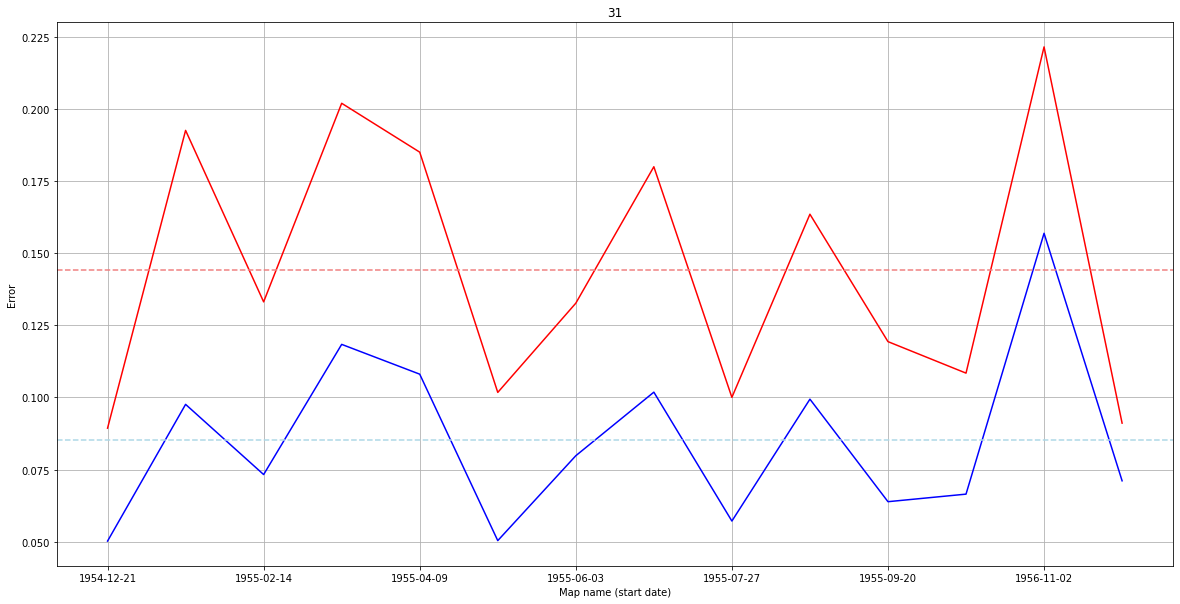

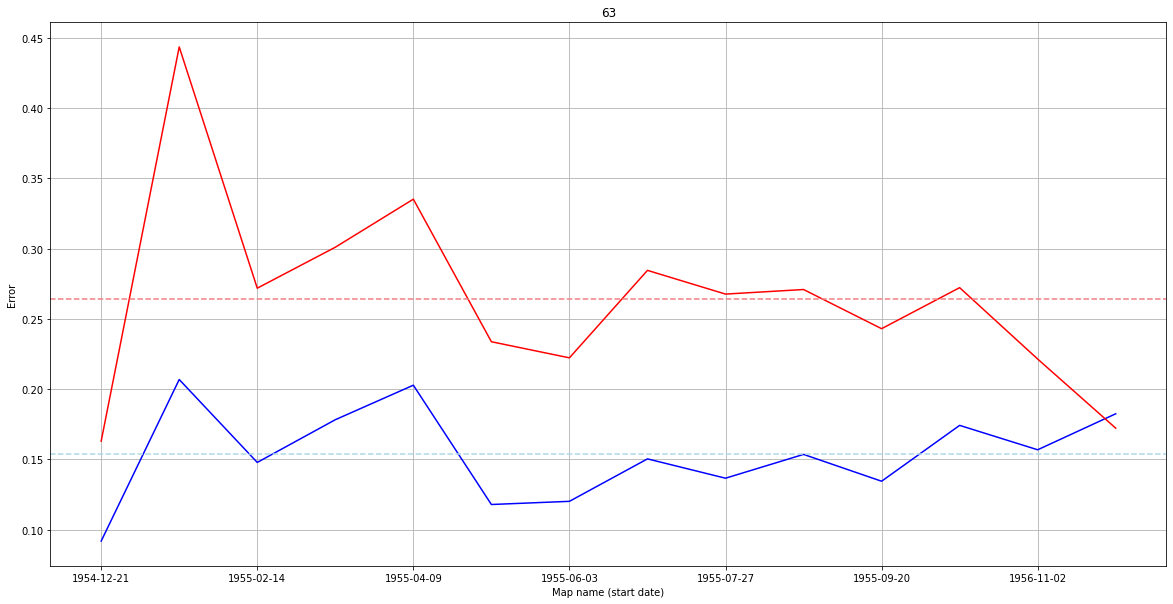

In [48]:
plot_errors(31)
plot_errors(63)

## Analysis of dataset

In [4]:
infodict = dict()
for path in tqdm(os.listdir(PATH_TO_MCINTOSH)):
    mapnum = path.split('_')[3]
    mapnum = mapnum[:4] + '-' + mapnum[4:6] + '-' + mapnum[6:]
    infodict[mapnum] = dict()
    with fits.open(os.path.join(PATH_TO_MCINTOSH, path)) as hdul:
        img = hdul[0].data[10:-10, 10:-10]
    filament = np.array(img != 9).astype(float)
    filament_complement = np.array(img != 8).astype(float)
    sign = np.array(img == 7).astype(float)
    n_filaments = len(np.unique(label(filament, background=1))[1:])
    filament_len = (1 - filament).sum()
    inv_line_len = (2 - (filament_complement + filament)).sum()
    sign_sum = (2*sign - 1).sum()
    infodict[mapnum]['n_filaments'] = n_filaments
    infodict[mapnum]['filament_len'] = filament_len
    infodict[mapnum]['inv_line_len'] = inv_line_len
    infodict[mapnum]['sign_sum'] = sign_sum

with open('./infodict.json', 'w') as f:
    json.dump(infodict, f)

100%|██████████| 732/732 [05:17<00:00,  2.31it/s]


In [5]:
TOTAL_PIXELS = 1989 * 3998
with open('./infodict.json', 'r') as f:
    infodict = json.load(f)
dates = np.array([x[:-3] for x in infodict.keys()])
n_filaments = np.array([x['n_filaments'] for x in infodict.values()])
filament_len = np.array([x['filament_len'] for x in infodict.values()])
inv_line_len = np.array([x['inv_line_len'] for x in infodict.values()])
sign_sum = np.array([x['sign_sum'] for x in infodict.values()])

normed_sign_sum = sign_sum / TOTAL_PIXELS
normed_inv = inv_line_len / TOTAL_PIXELS
normed_filament_len = filament_len / TOTAL_PIXELS
normed_ratio = filament_len / inv_line_len

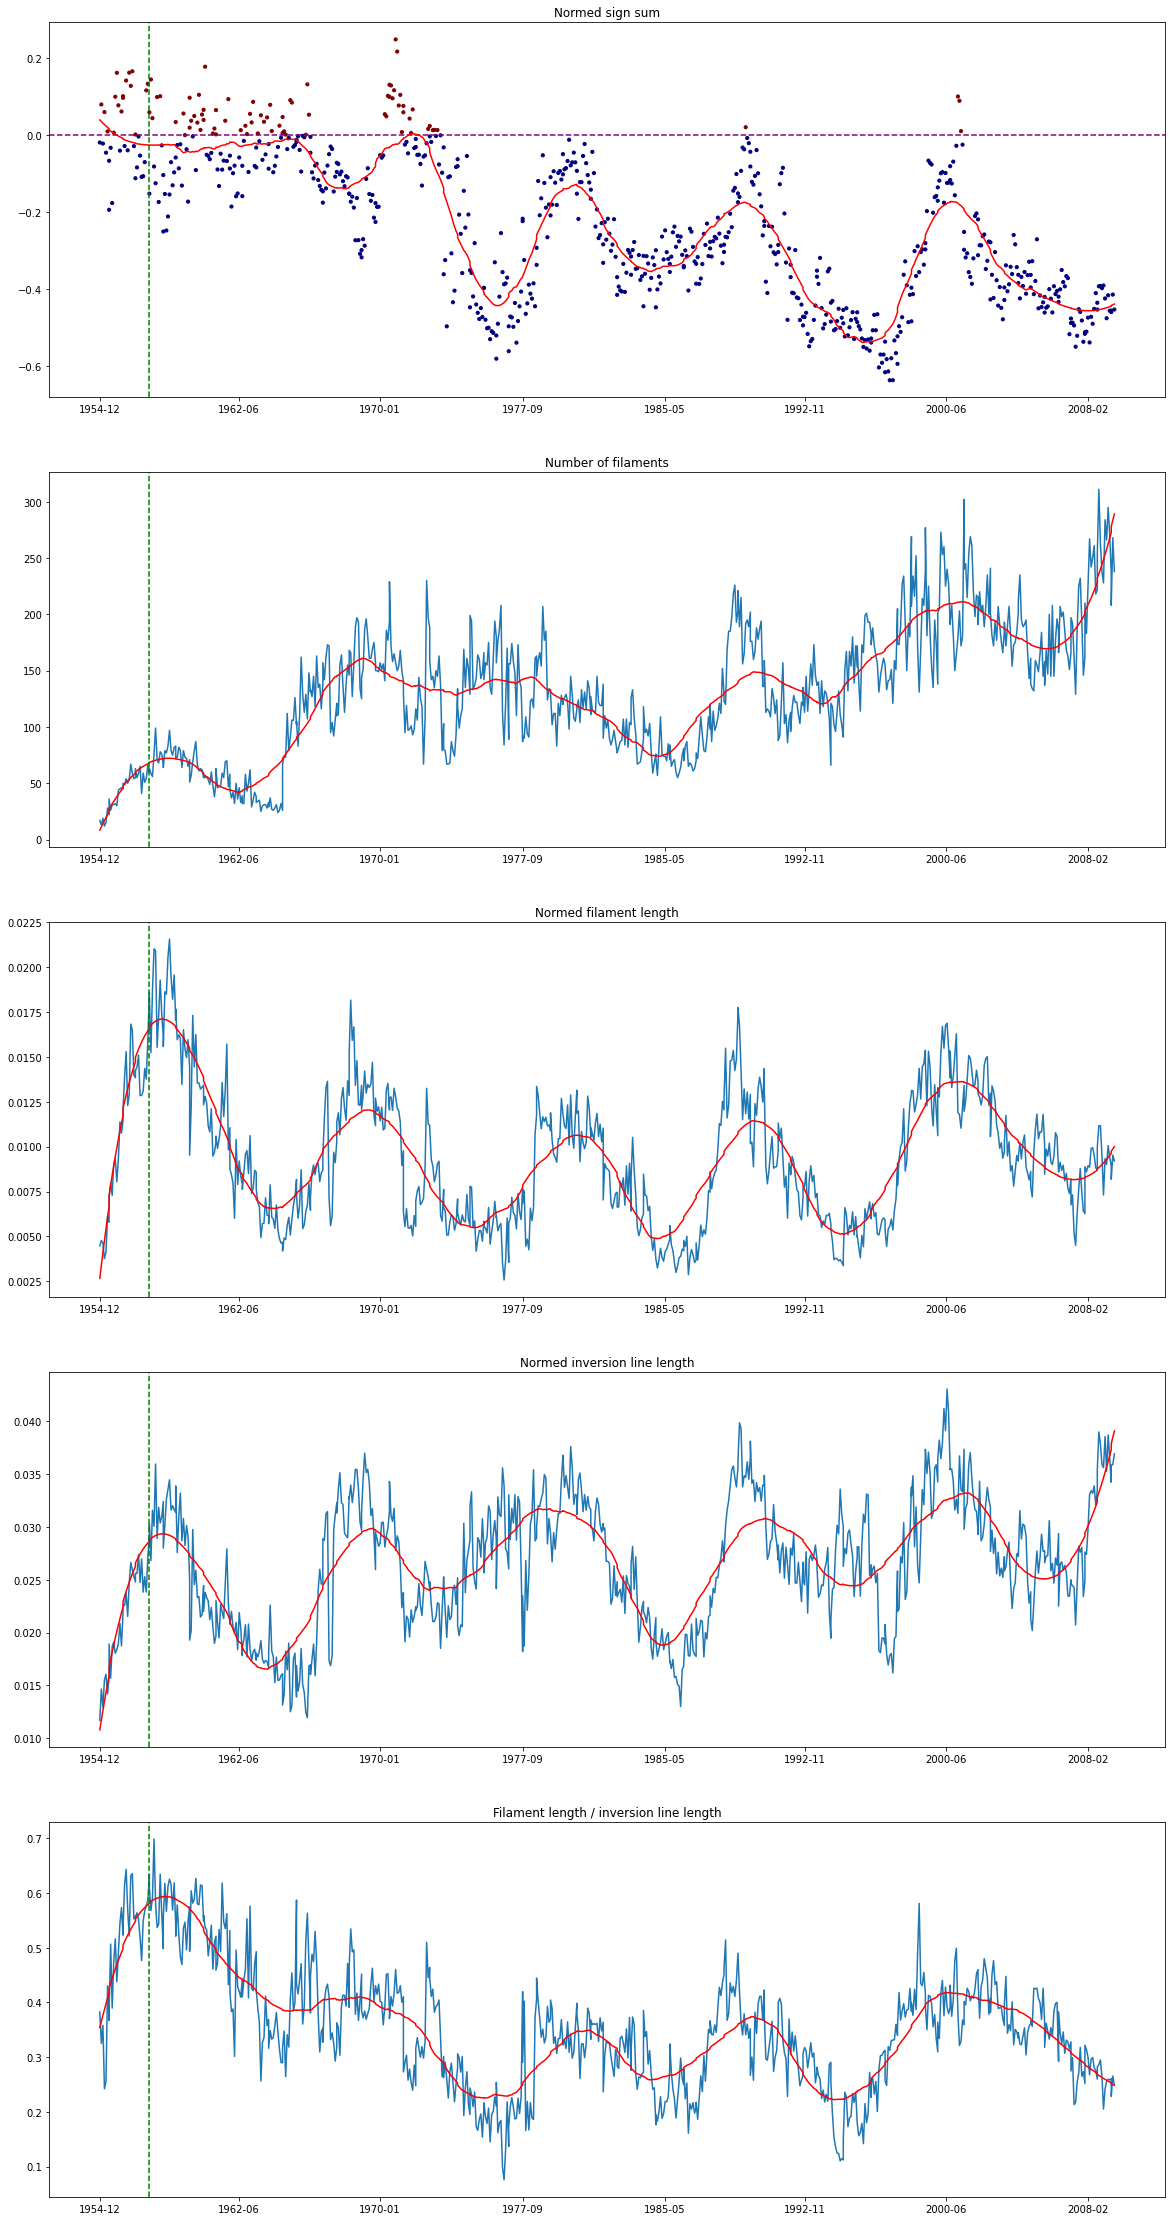

In [6]:
plt.figure(figsize=(20, 40))
plt.subplot(5, 1, 1)
plt.title('Normed sign sum')
vmax = np.abs(normed_sign_sum).max()
plt.scatter(dates, normed_sign_sum, c=sign_sum, cmap='jet', s=10, vmin=-vmax, vmax=vmax)
plt.axhline(y=0, color='purple', linestyle='--')
normed_sign_sum_smooth = signal.savgol_filter(normed_sign_sum, 100, 3)
plt.plot(dates, normed_sign_sum_smooth, color='r')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.axvline(x=dates[35], color='g', linestyle='--')

plt.subplot(5, 1, 2)
plt.title('Number of filaments')
plt.plot(dates, n_filaments)
n_filaments_smooth = signal.savgol_filter(n_filaments, 131, 3)
plt.plot(dates, n_filaments_smooth, color='r')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.axvline(x=dates[35], color='g', linestyle='--')

plt.subplot(5, 1, 3)
plt.title('Normed filament length')
plt.plot(dates, normed_filament_len)
normed_filament_len_smooth = signal.savgol_filter(normed_filament_len, 131, 3)
plt.plot(dates, normed_filament_len_smooth, color='r')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.axvline(x=dates[35], color='g', linestyle='--')

plt.subplot(5, 1, 4)
plt.title('Normed inversion line length')
plt.plot(dates, normed_inv)
normed_inv_smooth = signal.savgol_filter(normed_inv, 131, 3)
plt.plot(dates, normed_inv_smooth, color='r')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.axvline(x=dates[35], color='g', linestyle='--')

plt.subplot(5, 1, 5)
plt.title('Filament length / inversion line length')
plt.plot(dates, normed_ratio)
normed_ratio_smooth = signal.savgol_filter(normed_ratio, 131, 3)
plt.plot(dates, normed_ratio_smooth, color='r')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.axvline(x=dates[35], color='g', linestyle='--')